Problem Statement

Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

Data Dictionary:


RATINGS FILE DESCRIPTION

=========================================================================

All ratings are contained in the file "ratings.dat" and are in the following format:

UserID::MovieID::Rating::Timestamp

UserIDs range between 1 and 6040

MovieIDs range between 1 and 3952

Ratings are made on a 5-star scale (whole-star ratings only)

Timestamp is represented in seconds

Each user has at least 20 ratings

USERS FILE DESCRIPTION

=========================================================================

User information is in the file "users.dat" and is in the following format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is not checked for accuracy.
Only users who have provided some demographic information are included in this data set.

Gender is denoted by a "M" for male and "F" for female

Age is chosen from the following ranges:

1: "Under 18"

18: "18-24"

25: "25-34"

35: "35-44"

45: "45-49"

50: "50-55"

56: "56+"

Occupation is chosen from the following choices:

0: "other" or not specified

1: "academic/educator"

2: "artist"

3: "clerical/admin"

4: "college/grad student"

5: "customer service"

6: "doctor/health care"

7: "executive/managerial"

8: "farmer"

9: "homemaker"

10: "K-12 student"

11: "lawyer"

12: "programmer"

13: "retired"

14: "sales/marketing"

15: "scientist"

16: "self-employed"

17: "technician/engineer"

18: "tradesman/craftsman"

19: "unemployed"

20: "writer"

MOVIES FILE DESCRIPTION

=========================================================================

Movie information is in the file "movies.dat" and is in the following format:

MovieID::Title::Genres

Titles are identical to titles provided by the IMDB (including year of release)

Genres are pipe-separated and are selected from the following genres:

Action

Adventure

Animation

Children's

Comedy

Crime

Documentary

Drama

Fantasy

Film-Noir

Horror

Musical

Mystery

Romance

Sci-Fi

Thriller

War

Western


In [382]:
!pip install cmfrec

In [383]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


import matplotlib as mpl

from collections import defaultdict
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

from cmfrec import CMF
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error





In [384]:
!gdown 1Mpk9GBu9sHzMnb7EMSguihWgFSNSvX5W
!gdown 1InRFz7uEnvSh1sTmQ50GqDpnwXwKQmGw
!gdown 1ZmzsWbmr1SVmRczngXyMJ-YeEzsTFU2Y

Downloading...
From: https://drive.google.com/uc?id=1Mpk9GBu9sHzMnb7EMSguihWgFSNSvX5W
To: /content/zee-users.dat
100% 134k/134k [00:00<00:00, 90.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1InRFz7uEnvSh1sTmQ50GqDpnwXwKQmGw
To: /content/zee-ratings.dat
100% 24.6M/24.6M [00:00<00:00, 171MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZmzsWbmr1SVmRczngXyMJ-YeEzsTFU2Y
To: /content/zee-movies.dat
100% 171k/171k [00:00<00:00, 74.3MB/s]


In [385]:
df_users = pd.read_csv("zee-users.dat", delimiter='::', encoding='ISO-8859-1')
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [386]:
df_ratings = pd.read_csv("zee-ratings.dat", delimiter='::', encoding='ISO-8859-1')
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [387]:
df_movies = pd.read_csv("zee-movies.dat", delimiter='::', encoding='ISO-8859-1')
df_movies.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [388]:
df_users.shape
print(f"The users dataset has {df_users.shape[0]} rows and {df_users.shape[1]} columns")

The users dataset has 6040 rows and 5 columns


In [389]:
df_ratings.shape
print(f"The ratings dataset has {df_ratings.shape[0]} rows and {df_ratings.shape[1]} columns")

The ratings dataset has 1000209 rows and 4 columns


In [390]:
df_movies.shape
print(f"The movies dataset has {df_movies.shape[0]} rows and {df_movies.shape[1]} columns")

The movies dataset has 3883 rows and 3 columns


In [391]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [392]:
df_users.describe()

,UserID,Age,Occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [393]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [394]:
df_ratings.describe()

,UserID,MovieID,Rating,Timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [395]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie ID  3883 non-null   int64 
 1   Title     3883 non-null   object
 2   Genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [396]:
df_movies.describe()

,Movie ID
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


In [397]:
df_users.isna().sum().sort_values(ascending=False)

,0
UserID,0
Gender,0
Age,0
Occupation,0
Zip-code,0


In [398]:
df_ratings.isna().sum().sort_values(ascending=False)

,0
UserID,0
MovieID,0
Rating,0
Timestamp,0


In [399]:
df_movies.isna().sum().sort_values(ascending=False)

,0
Movie ID,0
Title,0
Genres,0


Replace spaces in column names with underscores for consistency

In [400]:
df_users.columns = df_users.columns.str.replace(' ', '_')
df_ratings.columns = df_ratings.columns.str.replace(' ', '_')
df_movies.columns = df_movies.columns.str.replace(' ', '_')

In [401]:
df_users.nunique().sort_values(ascending=False)

,0
UserID,6040
Zip-code,3439
Occupation,21
Age,7
Gender,2


In [402]:
df_ratings.nunique().sort_values(ascending=False)

,0
Timestamp,458455
UserID,6040
MovieID,3706
Rating,5


In [403]:
df_movies.nunique().sort_values(ascending=False)

,0
Movie_ID,3883
Title,3883
Genres,301


In [404]:
df_users.dtypes

,0
UserID,int64
Gender,object
Age,int64
Occupation,int64
Zip-code,object


In [405]:
df_ratings.dtypes

,0
UserID,int64
MovieID,int64
Rating,int64
Timestamp,int64


In [406]:
df_movies.dtypes

,0
Movie_ID,int64
Title,object
Genres,object




> Feature Engineering and Data transformation



In [407]:
# Split movie genres to the list
df_movies.Genres = df_movies.Genres.apply(lambda x: x.split('|'))

# Extract year from title
df_movies['Year'] = df_movies['Title'].str.extract(r'\((\d{4})\)')

# Remove the years from the 'Title' column
df_movies['Title'] = df_movies['Title'].str.replace(r'\(\d{4}\)', '', regex=True)

# Strip extra whitespace
df_movies['Title'] = df_movies['Title'].str.strip()


# Rating timestamp conversion to standard format
df_ratings.Timestamp = pd.to_datetime(df_ratings.Timestamp, unit='s')
# Date and Time data as feature of timestamp
df_ratings['RatingYear'] = df_ratings.Timestamp.dt.year
df_ratings['RatingMonth'] = df_ratings.Timestamp.dt.month
df_ratings['RatingDay'] = df_ratings.Timestamp.dt.day
df_ratings['RatingHour'] = df_ratings.Timestamp.dt.hour
df_ratings['Weekday'] = df_ratings.Timestamp.dt.day_name()

In [408]:
df_movies.head()

,Movie_ID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [409]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp,RatingYear,RatingMonth,RatingDay,RatingHour,Weekday
0,1,1193,5,2000-12-31 22:12:40,2000,12,31,22,Sunday
1,1,661,3,2000-12-31 22:35:09,2000,12,31,22,Sunday
2,1,914,3,2000-12-31 22:32:48,2000,12,31,22,Sunday
3,1,3408,4,2000-12-31 22:04:35,2000,12,31,22,Sunday
4,1,2355,5,2001-01-06 23:38:11,2001,1,6,23,Saturday


In [410]:
df_ratings_copy = df_ratings.copy(deep=True)
df_users_copy = df_users.copy(deep=True)
df_movies_copy = df_movies.copy(deep=True)

In [411]:
df_users.replace({
    'Age': {
        1: "Under 18",
        18: "18-24",
        25: "25-34",
        35: "35-44",
        45: "45-49",
        50: "50-55",
        56: "56 Above"
    }
}, inplace=True)

In [412]:
df_users.replace({'Occupation': {
    0:  "other",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10: "k-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}}, inplace=True)


In [413]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,k-12 student,48067
1,2,M,56 Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


In [414]:
df_movies.head()

,Movie_ID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


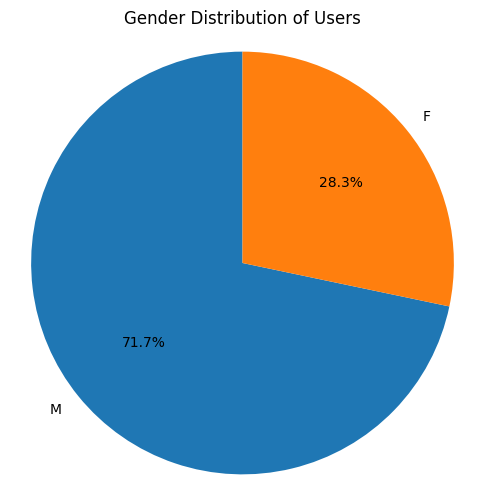

In [415]:
# Calculate gender distribution
gender_counts = df_users['Gender'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    gender_counts.values,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    startangle=90
)

# Add title
plt.title('Gender Distribution of Users')

# Ensure pie is a circle
plt.axis('equal')

# Show plot
plt.show()


In [416]:
df_users

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,k-12 student,48067
1,2,M,56 Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455
...,...,...,...,...,...
6035,6036,F,25-34,scientist,32603
6036,6037,F,45-49,academic/educator,76006
6037,6038,F,56 Above,academic/educator,14706
6038,6039,F,45-49,other,01060


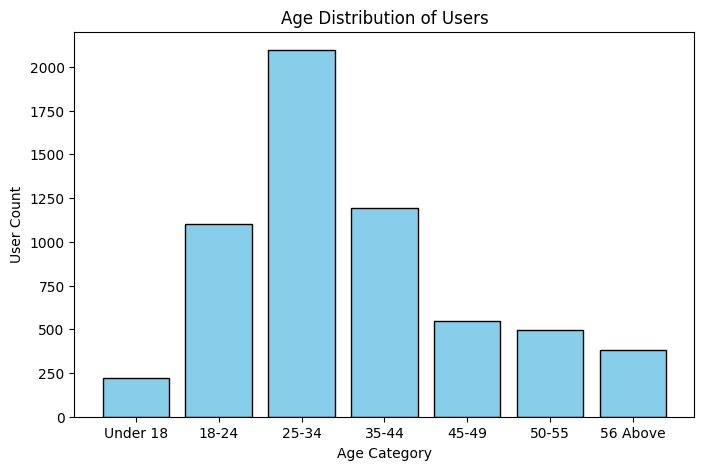

In [417]:
# Ensure consistent category order
age_order = ["Under 18", "18-24", "25-34", "35-44", "45-49", "50-55", "56 Above"]

age_counts = df_users['Age'].value_counts().reindex(age_order)

plt.figure(figsize=(8, 5))
plt.bar(age_counts.index, age_counts.values, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Users')
plt.xlabel('Age Category')
plt.ylabel('User Count')
plt.show()


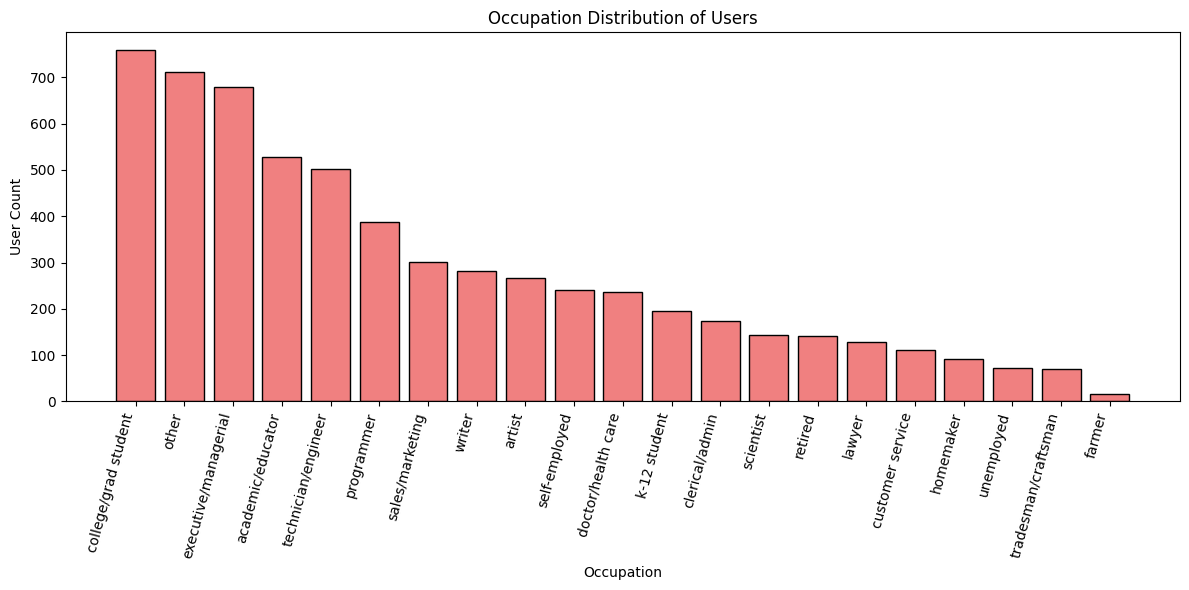

In [418]:
## Occupation wise distribution of users


# Occupation code-to-label mapping
occupation_dict = {
    0: "other", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
    4: "college/grad student", 5: "customer service", 6: "doctor/health care",
    7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student",
    11: "lawyer", 12: "programmer", 13: "retired", 14: "sales/marketing",
    15: "scientist", 16: "self-employed", 17: "technician/engineer",
    18: "tradesman/craftsman", 19: "unemployed", 20: "writer"
}

# Get occupation counts
occupation_counts = df_users['Occupation'].value_counts()
occupation_counts.rename(index=occupation_dict, inplace=True)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(occupation_counts.index, occupation_counts.values, color='lightcoral', edgecolor='black')

# Rotate x-axis labels for readability
plt.xticks(rotation=75, ha='right')

# Labels and title
plt.title('Occupation Distribution of Users')
plt.xlabel('Occupation')
plt.ylabel('User Count')

# Show plot
plt.tight_layout()
plt.show()


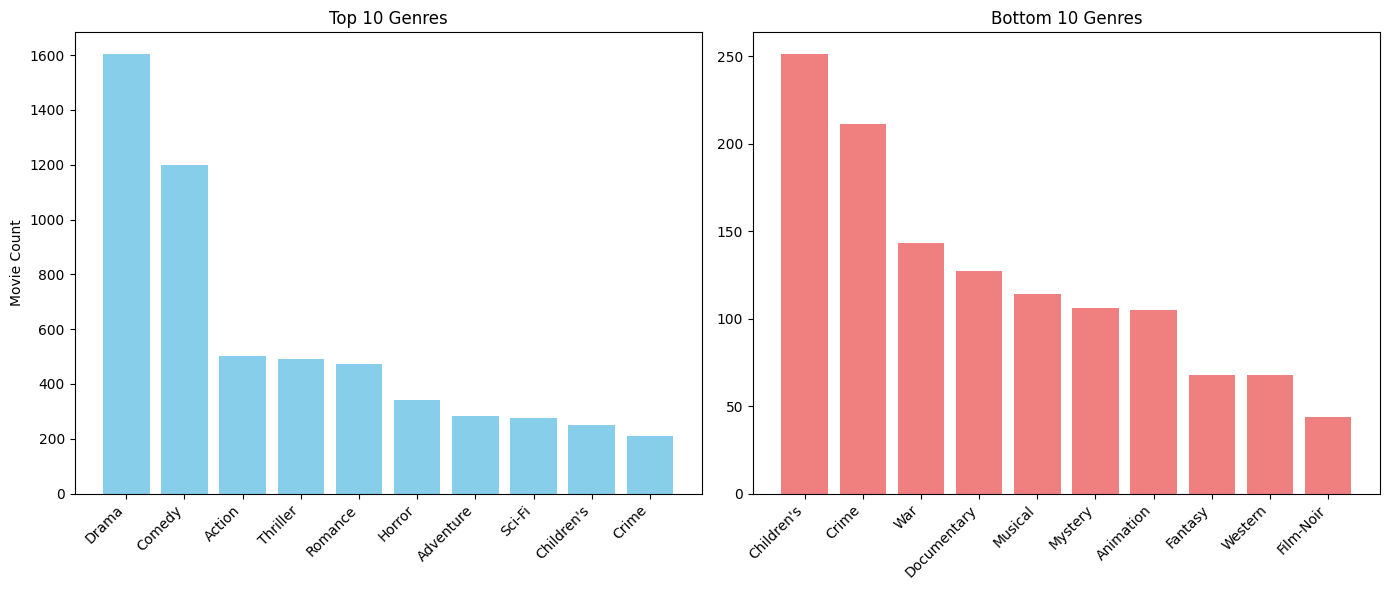

In [419]:
# Explode genres once to reuse
exploded_genres = df_movies.explode('Genres')

# Get top and bottom 10 genres by count
genre_counts = exploded_genres['Genres'].value_counts()
top_10 = genre_counts.head(10)
bottom_10 = genre_counts.tail(10)

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot top 10 genres
axes[0].bar(top_10.index, top_10.values, color='skyblue')
axes[0].set_title('Top 10 Genres')
axes[0].set_ylabel('Movie Count')
axes[0].set_xticklabels(top_10.index, rotation=45, ha='right')

# Plot bottom 10 genres
axes[1].bar(bottom_10.index, bottom_10.values, color='lightcoral')
axes[1].set_title('Bottom 10 Genres')
axes[1].set_xticklabels(bottom_10.index, rotation=45, ha='right')

# Adjust layout for readability
plt.tight_layout()
plt.show()


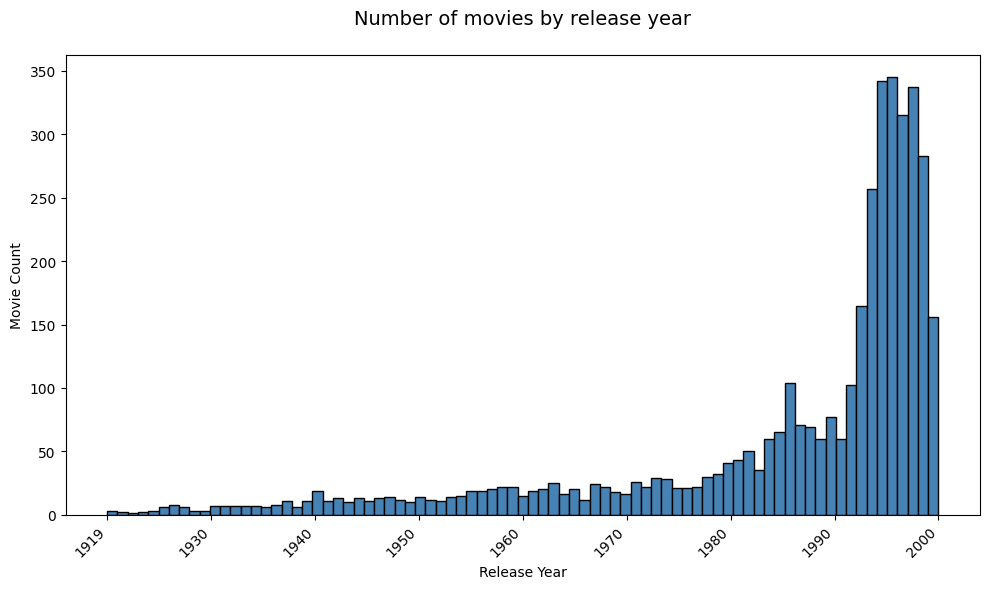

In [420]:
## Number of movies by release year

from matplotlib.ticker import MaxNLocator

sorted_years = df_movies['Year'].sort_values()

plt.figure(figsize=(10, 6))
plt.hist(sorted_years, bins=sorted_years.nunique(), color='steelblue', edgecolor='black')

plt.title('Number of movies by release year', fontsize=14, y=1.05)
plt.xlabel('Release Year')
plt.ylabel('Movie Count')

ax = plt.gca()
# Limit number of ticks to avoid overcrowding
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Mean rating score is 3.581564453029317
Median rating score is 4.0


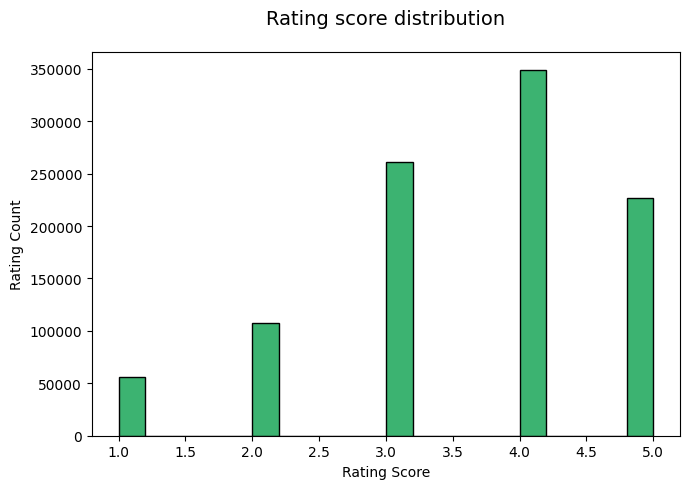

In [421]:
# Print mean and median rating
print(f'Mean rating score is {df_ratings.Rating.mean()}')
print(f'Median rating score is {df_ratings.Rating.median()}')

plt.figure(figsize=(7, 5))
plt.hist(df_ratings['Rating'], bins=20, color='mediumseagreen', edgecolor='black')

plt.title('Rating score distribution', fontsize=14, y=1.05)
plt.xlabel('Rating Score')
plt.ylabel('Rating Count')

plt.tight_layout()
plt.show()


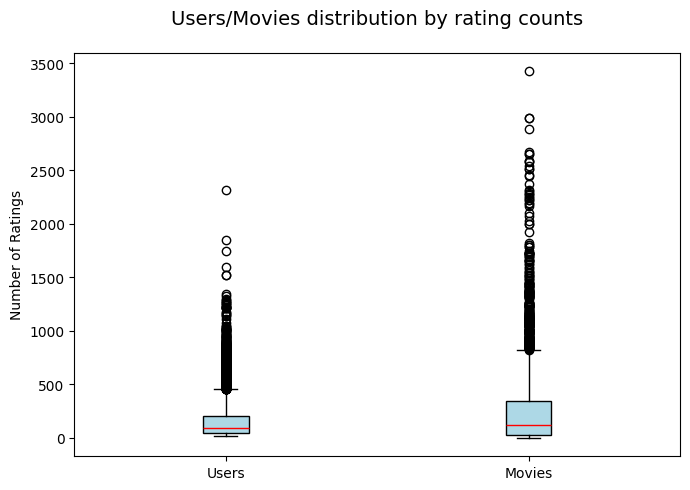

In [422]:
## Distribution of users and movies by rating counts

# Calculate rating counts per user and per movie
user_counts = df_ratings['UserID'].value_counts()
movie_counts = df_ratings['MovieID'].value_counts()

plt.figure(figsize=(7, 5))
plt.boxplot([user_counts, movie_counts], labels=['Users', 'Movies'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red'))

plt.ylabel('Number of Ratings')
plt.title('Users/Movies distribution by rating counts', fontsize=14, y=1.05)

plt.tight_layout()
plt.show()


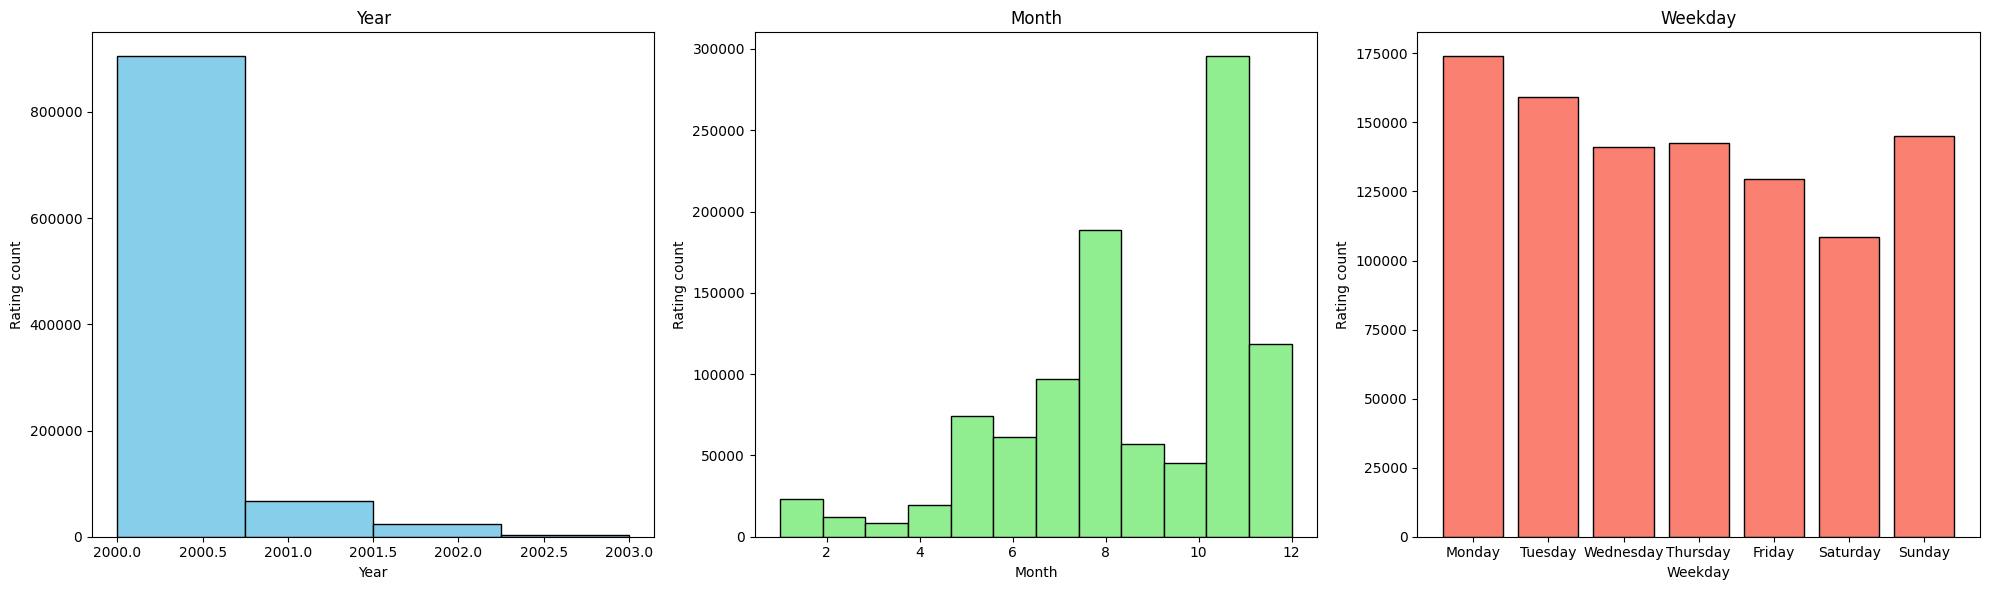

In [423]:
## Yearwise ratings given to movies

# Order weekdays properly
ordered_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_ratings['Weekday'] = pd.Categorical(df_ratings['Weekday'], categories=ordered_weekdays, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Histogram for RatingYear
axes[0].hist(df_ratings['RatingYear'], bins=df_ratings['RatingYear'].nunique(), color='skyblue', edgecolor='black')
axes[0].set_title('Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Rating count')

# Histogram for RatingMonth
axes[1].hist(df_ratings['RatingMonth'], bins=12, color='lightgreen', edgecolor='black')
axes[1].set_title('Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Rating count')

# Histogram for Weekday with categorical ordering
# We count values manually to ensure order and then plot as bar chart
weekday_counts = df_ratings['Weekday'].value_counts().reindex(ordered_weekdays)
axes[2].bar(weekday_counts.index, weekday_counts.values, color='salmon', edgecolor='black')
axes[2].set_title('Weekday')
axes[2].set_xlabel('Weekday')
axes[2].set_ylabel('Rating count')

plt.tight_layout()
plt.show()


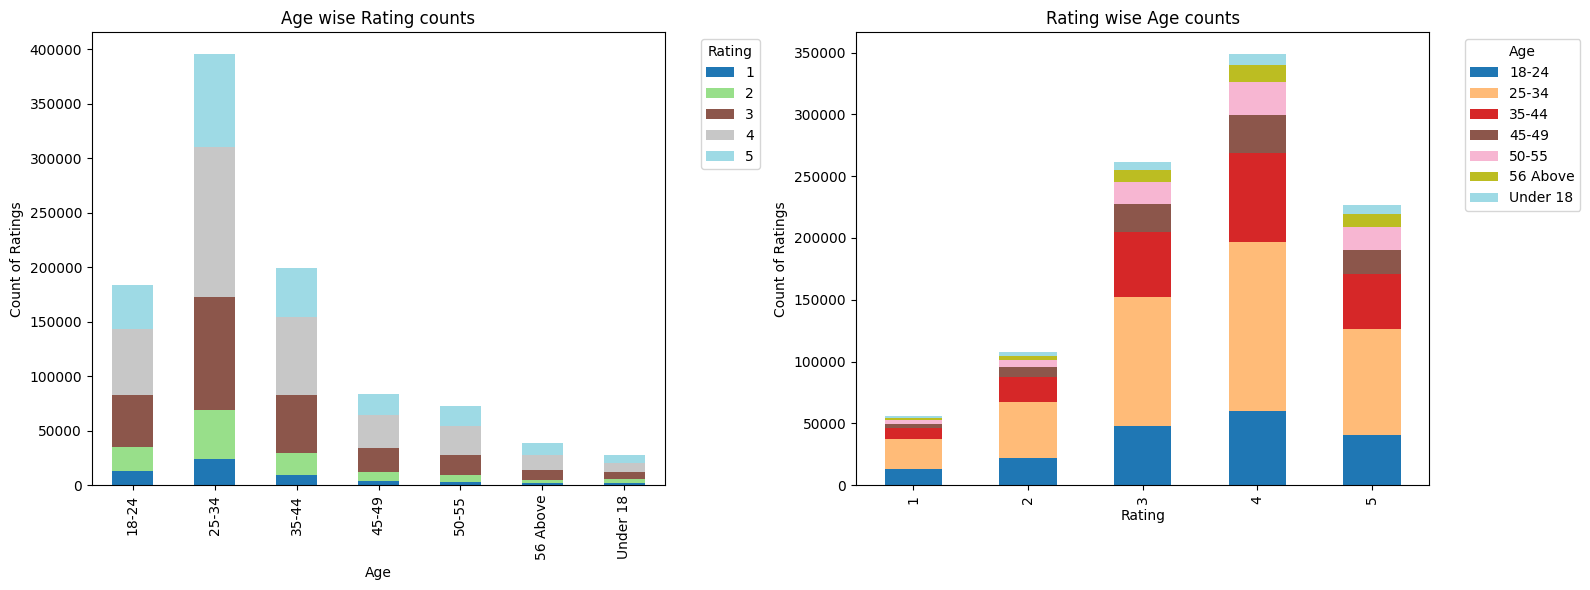

In [424]:
## Genre wise rating

# Merge and group data
age_rating = pd.merge(df_ratings, df_users, on='UserID', how='left')
grouped = age_rating.groupby(['Age', 'Rating']).size().unstack(fill_value=0)
grouped2 = age_rating.groupby(['Rating', 'Age']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) Age wise Rating counts (Age on x, ratings stacked)
grouped.plot(kind='bar', stacked=True, ax=axes[0], colormap='tab20')
axes[0].set_title('Age wise Rating counts')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count of Ratings')
axes[0].legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')

# 2) Rating wise Age counts (Rating on x, ages stacked)
grouped2.plot(kind='bar', stacked=True, ax=axes[1], colormap='tab20')
axes[1].set_title('Rating wise Age counts')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Count of Ratings')
axes[1].legend(title='Age', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


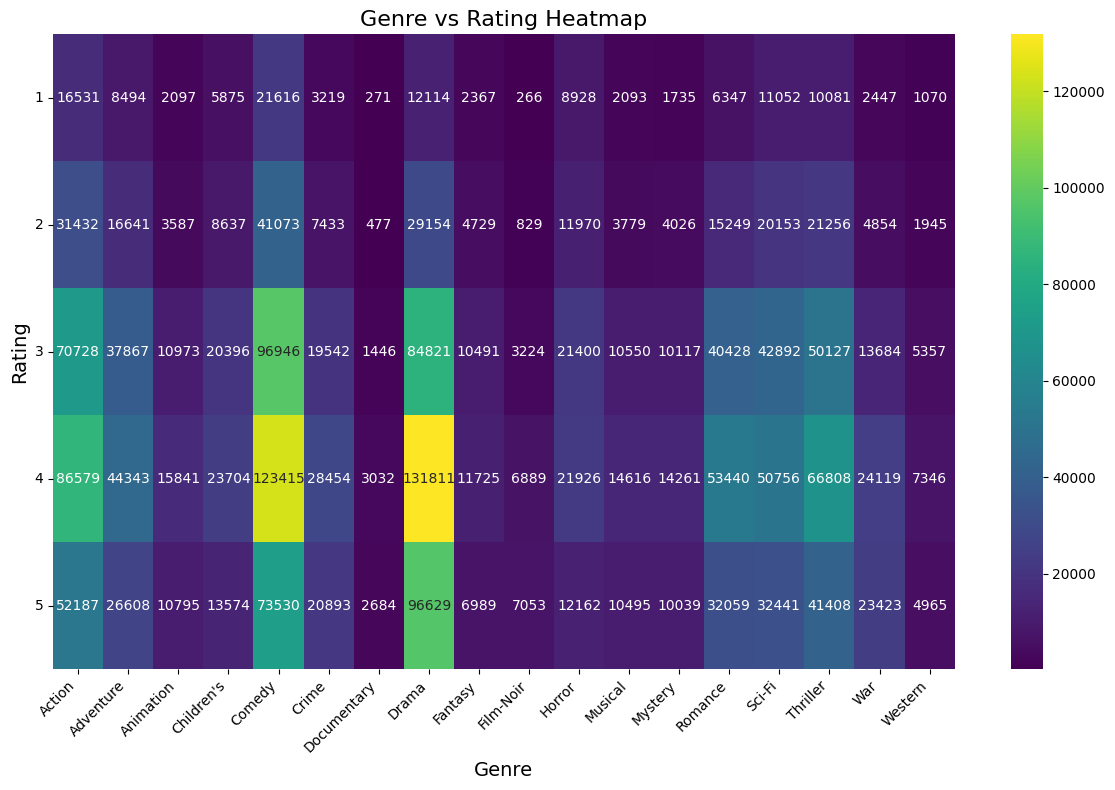

In [425]:
## Genre v/s Rating Heatmap

# Prepare the data (same as before)
genre_rating = pd.merge(
    df_ratings,
    df_movies.explode('Genres'),
    left_on='MovieID',
    right_on='Movie_ID',
    how='left'
)

genre_rating = (
    genre_rating
    .groupby(['Rating', 'Genres'])
    .size()
    .reset_index(name='count')
    .pivot(index='Rating', columns='Genres', values='count')
    .fillna(0)
)

plt.figure(figsize=(12, 8))
sns.heatmap(genre_rating, cmap='viridis', annot=True, fmt='.0f')

plt.title('Genre vs Rating Heatmap', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.yticks(rotation=0)  # keep y labels horizontal
plt.xticks(rotation=45, ha='right')  # rotate x labels for readability

plt.tight_layout()
plt.show()


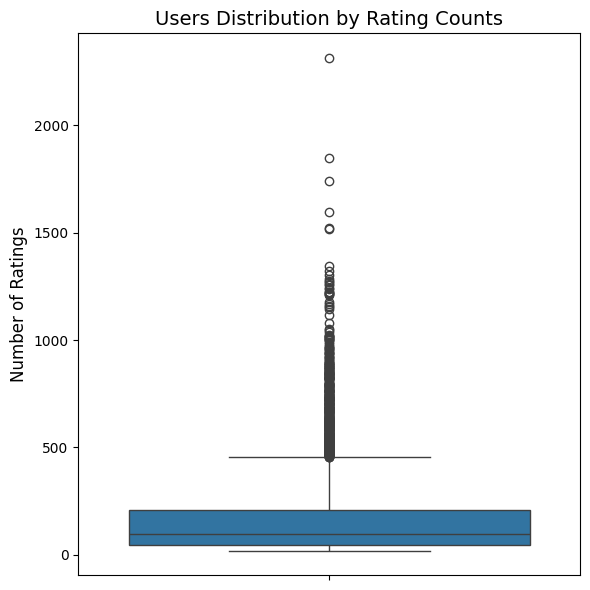

In [426]:
user_rating_counts = df_ratings['UserID'].value_counts()

plt.figure(figsize=(6, 6))
sns.boxplot(y=user_rating_counts)

plt.ylabel('Number of Ratings', fontsize=12)
plt.title('Users Distribution by Rating Counts', fontsize=14)

plt.tight_layout()
plt.show()

In [427]:
df_ratings.rename(columns={
    'MovieID': 'Movie_ID'
}, inplace=True)

In [428]:
df_movies_ratings = pd.merge(df_movies, df_ratings, how='inner', on='Movie_ID')
df_movies_ratings.head()
data = pd.merge(df_movies_ratings, df_users, how='inner', on='UserID')
data.head()

,Movie_ID,Title,Genres,Year,UserID,Rating,Timestamp,RatingYear,RatingMonth,RatingDay,RatingHour,Weekday,Gender,Age,Occupation,Zip-code
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,2001-01-06 23:37:48,2001,1,6,23,Saturday,F,Under 18,k-12 student,48067
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,2000-12-31 04:30:08,2000,12,31,4,Sunday,F,50-55,homemaker,55117
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,2000-12-31 03:31:36,2000,12,31,3,Sunday,M,25-34,programmer,11413
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,2000-12-31 01:25:52,2000,12,31,1,Sunday,M,25-34,technician/engineer,61614
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,2000-12-31 01:34:34,2000,12,31,1,Sunday,F,35-44,academic/educator,95370


In [429]:
missing_value = pd.DataFrame({
    'Missing Value': data.isnull().sum(),
    'Percentage': (data.isnull().sum() / len(data))*100
})
missing_value.sort_values(by='Percentage', ascending=False)

,Missing Value,Percentage
Movie_ID,0,0.0
Title,0,0.0
Genres,0,0.0
Year,0,0.0
UserID,0,0.0
Rating,0,0.0
Timestamp,0,0.0
RatingYear,0,0.0
RatingMonth,0,0.0
RatingDay,0,0.0


In [430]:
data['Datetime'] = pd.to_datetime(data['Timestamp'], unit='s') #Change the datatype from object to date_time
data['Year']=data['Year'].astype('int32') #Change the datatype from object to Integer
data['Rating']=data['Rating'].astype('int32') #Change the datatype from object to Integer

In [431]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['ReleaseDec'] = pd.cut(data['Year'], bins=bins, labels=labels)

In [432]:
data.head()

,Movie_ID,Title,Genres,Year,UserID,Rating,Timestamp,RatingYear,RatingMonth,RatingDay,RatingHour,Weekday,Gender,Age,Occupation,Zip-code,Datetime,ReleaseDec
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,2001-01-06 23:37:48,2001,1,6,23,Saturday,F,Under 18,k-12 student,48067,2001-01-06 23:37:48,90s
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,2000-12-31 04:30:08,2000,12,31,4,Sunday,F,50-55,homemaker,55117,2000-12-31 04:30:08,90s
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,2000-12-31 03:31:36,2000,12,31,3,Sunday,M,25-34,programmer,11413,2000-12-31 03:31:36,90s
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,2000-12-31 01:25:52,2000,12,31,1,Sunday,M,25-34,technician/engineer,61614,2000-12-31 01:25:52,90s
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,2000-12-31 01:34:34,2000,12,31,1,Sunday,F,35-44,academic/educator,95370,2000-12-31 01:34:34,90s


In [433]:
#@title Recommendations systems

In [434]:
#@title User-Interaction Matrix

matrix = pd.pivot_table(data, index='UserID', columns='Title', values='Rating', aggfunc='mean')
matrix.fillna(0, inplace=True) # Imputing 'NaN' values with Zero rating

print(matrix.shape)

matrix.head(10)

(6040, 3664)


Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [435]:
# Checking data sparsity
n_users = data['UserID'].nunique()
n_movies = data['Movie_ID'].nunique()
sparsity = round(1.0 - data.shape[0] / float( n_users * n_movies), 3)
print('The sparsity level of dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of dataset is 95.5%


In [436]:
#@title Pearson Correlation

Correlation is a measure that tells how closely two variables move in the same or opposite direction. A positive value indicates that they move in the same direction (i.e. if one increases other increases), where as a negative value indicates the opposite.

The most popular correlation measure for numerical data is Pearson’s Correlation. This measures
the degree of linear relationship between two numeric variables and lies between -1 to +1. It is
represented by ‘r’.

* r=1 means perfect positive correlation
* r=-1 means perfect negative correlation
* r=0 means no linear correlation (note, it does not mean no correlation)

In [437]:
#@title Item - Based approach

In [438]:
data[data['Title']=='Home Alone']

,Movie_ID,Title,Genres,Year,UserID,Rating,Timestamp,RatingYear,RatingMonth,RatingDay,RatingHour,Weekday,Gender,Age,Occupation,Zip-code,Datetime,ReleaseDec
156660,586,Home Alone,"[Children's, Comedy]",1990,10,3,2000-12-31 02:12:27,2000,12,31,2,Sunday,F,35-44,academic/educator,95370,2000-12-31 02:12:27,90s
156661,586,Home Alone,"[Children's, Comedy]",1990,11,1,2001-01-07 21:52:36,2001,1,7,21,Sunday,F,25-34,academic/educator,04093,2001-01-07 21:52:36,90s
156662,586,Home Alone,"[Children's, Comedy]",1990,18,4,2000-12-30 05:47:13,2000,12,30,5,Saturday,F,18-24,clerical/admin,95825,2000-12-30 05:47:13,90s
156663,586,Home Alone,"[Children's, Comedy]",1990,22,3,2000-12-30 05:31:07,2000,12,30,5,Saturday,M,18-24,scientist,53706,2000-12-30 05:31:07,90s
156664,586,Home Alone,"[Children's, Comedy]",1990,26,2,2000-12-30 01:34:09,2000,12,30,1,Saturday,M,25-34,executive/managerial,23112,2000-12-30 01:34:09,90s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157330,586,Home Alone,"[Children's, Comedy]",1990,5991,3,2001-09-10 03:33:50,2001,9,10,3,Monday,F,35-44,writer,94025,2001-09-10 03:33:50,90s
157331,586,Home Alone,"[Children's, Comedy]",1990,5996,3,2000-08-14 17:57:25,2000,8,14,17,Monday,F,25-34,other,87114,2000-08-14 17:57:25,90s
157332,586,Home Alone,"[Children's, Comedy]",1990,6000,3,2000-04-28 01:18:42,2000,4,28,1,Friday,M,45-49,technician/engineer,30075,2000-04-28 01:18:42,90s
157333,586,Home Alone,"[Children's, Comedy]",1990,6006,2,2000-04-29 18:37:11,2000,4,29,18,Saturday,F,Under 18,other,01036,2000-04-29 18:37:11,90s


In [439]:
#movie_name = input("Enter a movie name: ")
movie_name='Home Alone'
movie_rating = matrix[movie_name] # Taking the ratings of that movie
print(movie_rating)

UserID
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
6036    0.0
6037    0.0
6038    0.0
6039    0.0
6040    0.0
Name: Home Alone, Length: 6040, dtype: float64


In [440]:
similar_movies = matrix.corrwith(movie_rating) #Finding similar movies

sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True) # Sorting the values based on correlation

sim_df.iloc[1: , :].head() #Top 5 correlated movies.

,Correlation
Title,
Home Alone 2: Lost in New York,0.547203
Mrs. Doubtfire,0.468281
Liar Liar,0.455967
"Mighty Ducks, The",0.446273
Sister Act,0.444612


In [441]:
#@title Cosine Similarty

Cosine similarity is a measure of similarity between two sequences of numbers. Those sequences are viewed as vectors in a higher dimensional space, and the cosine similarity is defined as the cosine of the angle between them, i.e. the dot product of the vectors divided by the product of their lengths.

The cosine similarity always belongs to the interval [-1,1]. For example, two proportional vectors have a cosine similarity of 1, two orthogonal vectors have a similarity of 0, and two opposite vectors have a similarity of -1.

In [442]:
item_sim = cosine_similarity(matrix.T) #Finding the similarity values between item-item using cosine_similarity
item_sim

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

In [443]:
item_sim.shape

(3664, 3664)

In [444]:
#@title Item-Based Similarity

In [445]:
item_sim_matrix = pd.DataFrame(item_sim, index=matrix.columns, columns=matrix.columns)
item_sim_matrix.head() #Item-similarity Matrix

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


In [446]:
#@title  User-Based Similarity

In [447]:
user_sim = cosine_similarity(matrix) #Finding the similarity values between user-user using cosine_similarity
user_sim

array([[1.        , 0.09638153, 0.12060981, ..., 0.        , 0.17460369,
        0.13359025],
       [0.09638153, 1.        , 0.1514786 , ..., 0.06611767, 0.0664575 ,
        0.21827563],
       [0.12060981, 0.1514786 , 1.        , ..., 0.12023352, 0.09467506,
        0.13314404],
       ...,
       [0.        , 0.06611767, 0.12023352, ..., 1.        , 0.16171426,
        0.09930008],
       [0.17460369, 0.0664575 , 0.09467506, ..., 0.16171426, 1.        ,
        0.22833237],
       [0.13359025, 0.21827563, 0.13314404, ..., 0.09930008, 0.22833237,
        1.        ]])

In [448]:
user_sim_matrix = pd.DataFrame(user_sim, index=matrix.index, columns=matrix.index)
user_sim_matrix.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.254736,...,0.170588,0.082006,0.090961,0.033663,0.114877,0.186957,0.136233,0.000000,0.174604,0.133590
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.211120,0.190198,0.227745,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.229011,0.206660,0.066118,0.066457,0.218276
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.214487,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143747,0.107945,0.120234,0.094675,0.133144
4,0.132455,0.171176,0.151227,1.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.121208,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.171158,0.127703,0.062907,0.064634,0.137968
5,0.090158,0.114394,0.062907,0.045094,1.000000,0.047449,0.126257,0.220817,0.261330,0.117508,...,0.100652,0.035732,0.065278,0.054151,0.179083,0.294354,0.173009,0.020459,0.027689,0.241437


In [449]:
#@title Nearest Neighbors

In [450]:
model_knn = NearestNeighbors(metric='cosine')
model_knn.fit(matrix.T)

NearestNeighbors(metric='cosine')

In [451]:
##The distances and indices are being calculated with neighbors being 6
distances, indices = model_knn.kneighbors(matrix.T, n_neighbors= 6)

In [452]:
result = pd.DataFrame(indices, columns=['Title1', 'Title2', 'Title3', 'Title4', 'Title5','Title6'])
result.head()
#The result dataframe consits of the different indices of movies based on the distance

,Title1,Title2,Title3,Title4,Title5,Title6
0,0,737,417,287,585,3266
1,1,809,73,2181,3054,3390
2,2,1637,2544,3340,2603,2012
3,3,1467,2183,1318,1054,3533
4,4,26,728,897,496,947


In [453]:
##With this for loop replacing the indices in the result dataframe with movie titles of that corresponding ones
result2 = result.copy()
for i in range(1, 7):
    mov = pd.DataFrame(matrix.T.index).reset_index()
    mov = mov.rename(columns={'index':f'Title{i}'})
    result2 = pd.merge(result2, mov, on=[f'Title{i}'], how='left')
    result2 = result2.drop(f'Title{i}', axis=1)
    result2 = result2.rename(columns={'Title':f'Title{i}'})
result2.head()

,Title1,Title2,Title3,Title4,Title5,Title6
0,"$1,000,000 Duck","Computer Wore Tennis Shoes, The",Blackbeard's Ghost,"Barefoot Executive, The",Candleshoe,That Darn Cat!
1,'Night Mother,"Cry in the Dark, A",Agnes of God,Mommie Dearest,Sophie's Choice,"Trip to Bountiful, The"
2,'Til There Was You,If Lucy Fell,Picture Perfect,To Gillian on Her 37th Birthday,Practical Magic,Mad Love
3,"'burbs, The",Harry and the Hendersons,"Money Pit, The",Ghostbusters II,European Vacation,Weekend at Bernie's
4,...And Justice for All,52 Pick-Up,Coma,Deliverance,"Boys from Brazil, The",Dog Day Afternoon


In [454]:
#movie_name = input("Enter a movie name: ")
movie_name = 'Liar Liar'
result2.loc[result2['Title1']==movie_name] #5 nearest movies for the movie present in Title1.

,Title1,Title2,Title3,Title4,Title5,Title6
1899,Liar Liar,Mrs. Doubtfire,Ace Ventura: Pet Detective,Dumb & Dumber,Home Alone,Wayne's World


In [455]:
#@title Matrix Factorization

Creating a pivot table of movie titles and userid and ratings are taken as values

In [456]:
rm = data.pivot(index = 'UserID', columns ='Movie_ID', values = 'Rating').fillna(0)
rm.head()

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [457]:
#@title Using Cmfrec Library

In [458]:
user_itm = data[['UserID', 'Movie_ID', 'Rating']].copy()
user_itm.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
user_itm.head(2)

,UserId,ItemId,Rating
0,1,1,5
1,6,1,4


In [459]:
print(user_itm.shape)
print("No.of Users:",len(user_itm['UserId'].unique()))
print("No.of Items:",len(user_itm['ItemId'].unique()))

(1000209, 3)
No.of Users: 6040
No.of Items: 3706


In [460]:
model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(user_itm) #Fitting the model

Collective matrix factorization model
(explicit-feedback variant)


In [461]:
model.A_.shape, model.B_.shape #model.A_ gives the embeddings of Users and model.B_ gives the embeddings of Items.

((6040, 4), (3706, 4))

In [462]:
user_itm.Rating.mean(), model.glob_mean_  # Average rating and Global Mean

(np.float64(3.581564453029317), 3.581564426422119)

In [463]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_ #Calculating the predicted ratings
rmse = mean_squared_error(rm.values[rm > 0], rm__[rm > 0]) # calculating rmse value
print('Root Mean Squared Error: {:.3f}'.format(rmse))
mape =  mean_absolute_percentage_error(rm.values[rm > 0], rm__[rm > 0]) #calculating mape value
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

Root Mean Squared Error: 1.365
Mean Absolute Percentage Error: 0.346


Embeddings for user-user similarity.

In [464]:
user=cosine_similarity(model.A_)

user_sim_matrix = pd.DataFrame(user, index=matrix.index, columns=matrix.index)
user_sim_matrix.head()  #User similarity matrix using the embeddings from matrix factorization

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.001556,0.330752,-0.243099,0.781295,0.385959,0.017011,-0.611703,-0.457640,-0.532428,...,-0.101479,-0.513452,0.708202,0.441473,-0.110499,0.727700,0.803615,-0.241513,0.910400,0.294288
2,-0.001556,1.000000,-0.515879,0.039806,0.602824,0.313755,0.059894,-0.637603,0.060986,0.731933,...,0.993927,0.325497,0.686616,0.608659,0.327896,-0.220945,-0.547683,0.012561,-0.410187,0.645183
3,0.330752,-0.515879,1.000000,0.663703,-0.033458,0.533339,0.719866,0.494795,0.445378,-0.222793,...,-0.573610,0.031619,-0.222780,0.341757,0.119814,0.864029,0.483564,0.237854,0.529319,0.317337
4,-0.243099,0.039806,0.663703,1.000000,-0.152643,0.580663,0.931329,0.576095,0.907688,0.567793,...,0.027776,0.631281,-0.264363,0.549093,0.381714,0.443354,-0.309674,0.397198,-0.212017,0.624144
5,0.781295,0.602824,-0.033458,-0.152643,1.000000,0.584601,0.021669,-0.857913,-0.363016,0.022300,...,0.524725,-0.293387,0.951094,0.708002,0.252673,0.439718,0.330211,-0.034698,0.455625,0.650732


In [465]:
itm=cosine_similarity(model.B_)

itm_sim_matrix = pd.DataFrame(itm, index=user_itm['ItemId'].unique(), columns=user_itm['ItemId'].unique())
itm_sim_matrix.head()#Item similarity matrix using the embeddings from matrix factorization

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
1,1.000000,0.281080,-0.048290,-0.108233,0.067749,0.659104,0.324720,0.103334,-0.279493,0.489808,...,-0.002550,0.005146,-0.624506,-0.536338,0.319340,0.516991,0.276900,0.831040,0.837502,0.924333
2,0.281080,1.000000,0.919790,0.823825,0.954888,0.168801,0.955233,0.952895,0.794440,0.779625,...,0.627539,0.824073,0.487370,0.655865,0.428290,0.497772,-0.229141,0.602767,0.315467,0.503703
3,-0.048290,0.919790,1.000000,0.770813,0.959750,0.036122,0.892197,0.875405,0.953996,0.745976,...,0.530461,0.793472,0.620059,0.827221,0.140083,0.478387,-0.348608,0.246577,-0.042153,0.218849
4,-0.108233,0.823825,0.770813,1.000000,0.841995,-0.281402,0.715735,0.951469,0.723288,0.302748,...,0.760440,0.816691,0.843601,0.838813,0.627652,-0.032237,-0.310831,0.416005,0.124877,0.081499
5,0.067749,0.954888,0.959750,0.841995,1.000000,-0.079447,0.959800,0.920295,0.846683,0.679494,...,0.488864,0.727716,0.619639,0.784656,0.251117,0.347966,-0.480740,0.383217,0.034602,0.259716


In [466]:
movie_name=586
movie_rating = itm_sim_matrix[movie_name] # Taking the ratings of that movie
print(movie_rating)

1       0.265839
2       0.966962
3       0.935898
4       0.720481
5       0.970005
          ...   
3948    0.534284
3949   -0.391499
3950    0.484258
3951    0.163836
3952    0.451043
Name: 586, Length: 3706, dtype: float32


In [467]:
similar_movies = itm_sim_matrix.corrwith(movie_rating) #Finding similar movies

sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True) # Sorting the values based on correlation

sim_df.iloc[1: , :].head() #Top 5 correlated movies.

,Correlation
3482,0.998459
3594,0.997291
653,0.995545
2875,0.995394
3565,0.994582


In [468]:
item_mov = data[['Movie_ID', 'Title']].copy()
item_mov.drop_duplicates(inplace=True)
item_mov.reset_index(drop=True,inplace=True)

sim_df1= sim_df.copy()
sim_df1.reset_index(inplace=True)
sim_df1.rename(columns = {'index':'Movie_ID'}, inplace = True)
sim_mov = pd.merge(sim_df1,item_mov,on='Movie_ID',how='inner')
sim_mov.head(6)

,Movie_ID,Correlation,Title
0,586,1.000000,Home Alone
1,3482,0.998459,Price of Glory
2,3594,0.997291,Center Stage
3,653,0.995545,Dragonheart
4,2875,0.995394,Sommersby
5,3565,0.994582,Where the Heart Is


In [469]:
model1 = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model1.fit(user_itm)

Collective matrix factorization model
(explicit-feedback variant)


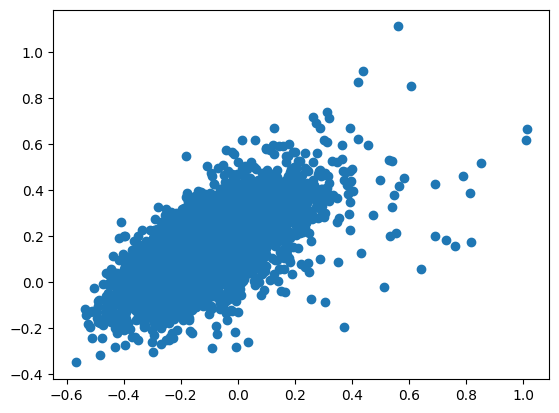

In [470]:
plt.scatter(model1.A_[:, 0], model1.A_[:, 1], cmap = 'hot')

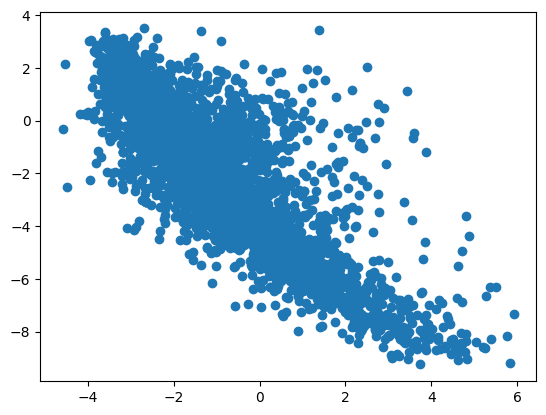

In [471]:
plt.scatter(model1.B_[:, 0], model1.B_[:, 1], cmap='hot')

User-Based Approach(optional)

In [472]:
#Taking 6 movies names in random
mov_name = ['Hamlet', 'Dumb & Dumber', 'Ace Ventura: Pet Detective', 'Home Alone','Robin Hood','It Happened One Night']

In [473]:
#Finding the MovieID's for the above movies
mov_id = []
for mov in mov_name:
    id = data[data['Title'] == mov]['Movie_ID'].iloc[0]
    mov_id.append(id)

In [474]:
#mov_rating = list(map(int, input("Rate these movies respectively: ").split()))
mov_rating = [5,3,2,1,4,3]#Give the random user rating for the movies

In [475]:
user_choices = pd.DataFrame({'Movie_ID': mov_id, 'Title': mov_name, 'Rating': mov_rating})
user_choices.sort_values(by='Movie_ID') #User choices

,Movie_ID,Title,Rating
1,231,Dumb & Dumber,3
2,344,Ace Ventura: Pet Detective,2
3,586,Home Alone,1
5,905,It Happened One Night,3
0,1411,Hamlet,5
4,3034,Robin Hood,4


In [476]:
other_users = data[data['Movie_ID'].isin(user_choices['Movie_ID'].values)] #Finding the similar users who watched same movies
other_users = other_users[['UserID', 'Movie_ID', 'Rating']]
other_users['UserID'].nunique()

1810

In [477]:
common_movies = other_users.groupby(['UserID']) #Grouping the data based on User who watched the common movies
common_movies = sorted(common_movies, key=lambda x: len(x[1]), reverse=True) #Soring the data so that who watched more number of common movies comes at the top.
common_movies[0]

((1605,),
         UserID  Movie_ID  Rating
 60910     1605       231       2
 92310     1605       344       3
 156847    1605       586       3
 216150    1605       905       4
 418869    1605      1411       3
 814313    1605      3034       4)

In [478]:
top_users = common_movies[:100] #Taking top 100 users who watched same movies as in user choices.

In [479]:
#Calculating pearson correlation
pearson_corr = {}

for user_id, movies in top_users:
    movies = movies.sort_values(by='Movie_ID')
    movie_list = movies['Movie_ID'].values #Taking list of movieid's

    new_user_ratings = user_choices[user_choices['Movie_ID'].isin(movie_list)]['Rating'].values # Taking the new user rating values based on user choices
    user_ratings = movies[movies['Movie_ID'].isin(movie_list)]['Rating'].values #Taking the actual rating values of the movies

    corr = pearsonr(new_user_ratings, user_ratings) # Calculating the correlation
    pearson_corr[user_id] = corr[0] #Correlation value for each UserID

In [480]:
pearson_df = pd.DataFrame(columns=['UserID', 'Similarity Index'], data=pearson_corr.items()) # Creating a dataframe for UserId and Correlation values as 'Similarity Index'
pearson_df = pearson_df.sort_values(by='Similarity Index', ascending=False)[:10] #Showing for top 10 Users
pearson_df

,UserID,Similarity Index
98,"(3224,)",0.943880
7,"(424,)",0.943456
73,"(1943,)",0.923381
35,"(5795,)",0.880705
43,"(524,)",0.870388
53,"(1019,)",0.870388
82,"(2507,)",0.852803
56,"(1112,)",0.774597
42,"(438,)",0.774597
89,"(2896,)",0.774597


In [481]:
pearson_df['UserID'] = pearson_df['UserID'].apply(lambda x: x[0] if isinstance(x, tuple) else x)
pearson_df['UserID'] = pearson_df['UserID'].astype(int)


In [482]:
users_rating = pearson_df.merge(data, on='UserID', how='inner') #Merging the original data with pearson correlation values
users_rating['Weighted Rating'] = users_rating['Rating'] * users_rating['Similarity Index'] # Calculating the Weighed rating for each user and movie
users_rating = users_rating[['UserID', 'Movie_ID', 'Rating', 'Similarity Index', 'Weighted Rating']]
users_rating

,UserID,Movie_ID,Rating,Similarity Index,Weighted Rating
0,3224,2,3,0.943880,2.831639
1,3224,3,4,0.943880,3.775519
2,3224,6,4,0.943880,3.775519
3,3224,7,3,0.943880,2.831639
4,3224,10,3,0.943880,2.831639
...,...,...,...,...,...
8697,2896,3826,3,0.774597,2.323790
8698,2896,3861,3,0.774597,2.323790
8699,2896,3863,3,0.774597,2.323790
8700,2896,3869,3,0.774597,2.323790


In [483]:
# Calculate sum of similarity index and weighted rating for each movie
grouped_ratings = users_rating.groupby('Movie_ID').sum()[['Similarity Index', 'Weighted Rating']]

recommend_movies = pd.DataFrame()

# Add average recommendation score.
# We're calculating average recommendation score by dividing the Weighted Rating by the Similarity Index.
recommend_movies['avg_reccomend_score'] = grouped_ratings['Weighted Rating']/grouped_ratings['Similarity Index']
recommend_movies['Movie_ID'] = grouped_ratings.index
recommend_movies = recommend_movies.reset_index(drop=True)

# Select movies with the highest score i.e. 5
recommend_movies = recommend_movies[(recommend_movies['avg_reccomend_score'] == 5)]

In [484]:
recommendations = data[data['Movie_ID'].isin(recommend_movies['Movie_ID'])][['Movie_ID', 'Title']].sample(10)
recommendations

,Movie_ID,Title
217354,908,North by Northwest
304323,1199,Brazil
235691,950,"Thin Man, The"
518003,1938,"Lost Weekend, The"
304893,1199,Brazil
487227,1734,My Life in Pink (Ma vie en rose)
627960,2325,Orgazmo
736435,2721,Trick
354248,1264,Diva
86952,319,Shallow Grave


In [485]:
#@title Regression Based Rec Sys

In [486]:
from sklearn.preprocessing import StandardScaler

In [487]:
df_movies_copy.head()

,Movie_ID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [488]:
df_ratings_copy.head()

,UserID,MovieID,Rating,Timestamp,RatingYear,RatingMonth,RatingDay,RatingHour,Weekday
0,1,1193,5,2000-12-31 22:12:40,2000,12,31,22,Sunday
1,1,661,3,2000-12-31 22:35:09,2000,12,31,22,Sunday
2,1,914,3,2000-12-31 22:32:48,2000,12,31,22,Sunday
3,1,3408,4,2000-12-31 22:04:35,2000,12,31,22,Sunday
4,1,2355,5,2001-01-06 23:38:11,2001,1,6,23,Saturday


In [489]:
df_users_copy.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [490]:
genres_df = pd.get_dummies(df_movies_copy['Genres'].apply(pd.Series).stack()).groupby(level=0).sum()
genres_df.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [491]:
m = pd.concat([df_movies_copy['Movie_ID'],genres_df.iloc[:,1:]],axis=1)
m.head()

,Movie_ID,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [492]:
from datetime import datetime
r = df_ratings_copy.copy()

# Convert 'Timestamp' to datetime dtype
r['Timestamp'] = pd.to_datetime(r['Timestamp'])

# Extract hour
r['hour'] = r['Timestamp'].dt.hour

# You can keep 'Rating' as int
r['Rating'] = r['Rating'].astype(int)

r.head()

,UserID,MovieID,Rating,Timestamp,RatingYear,RatingMonth,RatingDay,RatingHour,Weekday,hour
0,1,1193,5,2000-12-31 22:12:40,2000,12,31,22,Sunday,22
1,1,661,3,2000-12-31 22:35:09,2000,12,31,22,Sunday,22
2,1,914,3,2000-12-31 22:32:48,2000,12,31,22,Sunday,22
3,1,3408,4,2000-12-31 22:04:35,2000,12,31,22,Sunday,22
4,1,2355,5,2001-01-06 23:38:11,2001,1,6,23,Saturday,23


In [493]:
df_users2 = df_users_copy.merge(r.groupby('UserID').Rating.mean().reset_index(), on='UserID')
df_users2 = df_users2.merge(r.groupby('UserID').hour.mean().reset_index(), on='UserID')
df_users2.head(2)

,UserID,Gender,Age,Occupation,Zip-code,Rating,hour
0,1,F,1,10,48067,4.188679,22.245283
1,2,M,56,16,70072,3.713178,21.155039


In [494]:
u = df_users2[['UserID','Age', 'Rating', 'hour']].copy()
u = u.set_index('UserID')
u .columns = ['Age', 'User_avg_rating', 'hour']

scaler = StandardScaler()
u = pd.DataFrame(scaler.fit_transform(u), columns=u.columns, index=u.index)
u.head(2)

,Age,User_avg_rating,hour
UserID,,,
1,-2.298525,1.131261,1.414540
2,1.966729,0.024380,1.261846


In [495]:
df_cat = df_users2[['Gender','Occupation']]
df_cat['Gender']=pd.get_dummies(df_cat['Gender'], columns=['Gender'],drop_first=True)
df_cat = pd.concat([df_users_copy['UserID'],df_cat],axis=1)
df_cat.head()

,UserID,Gender,Occupation
0,1,False,10
1,2,True,16
2,3,True,15
3,4,True,7
4,5,True,20


In [496]:
print(u.columns)


Index(['Age', 'User_avg_rating', 'hour'], dtype='object')


In [497]:
X = df_ratings_copy[['MovieID', 'UserID', 'Rating']].copy()
X = X.merge(u.reset_index(), on='UserID', how='right')
X = X.merge(m.reset_index(), left_on='MovieID', right_on='Movie_ID', how='right')
X = X.merge(df_cat, on='UserID', how='right')
X.drop(columns=['index'], axis=1, inplace=True)
X.dropna(inplace=True)
X.reset_index(inplace=True,drop=True)
X1=X.copy()
X.head()

,MovieID,UserID,Rating,Age,User_avg_rating,hour,Movie_ID,Adventure,Animation,Children's,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Gender,Occupation
0,1.0,1.0,5.0,-2.298525,1.131261,1.41454,1,0,1,1,...,0,0,0,0,0,0,0,0,False,10
1,48.0,1.0,5.0,-2.298525,1.131261,1.41454,48,0,1,1,...,0,1,0,1,0,0,0,0,False,10
2,150.0,1.0,5.0,-2.298525,1.131261,1.41454,150,0,0,0,...,0,0,0,0,0,0,0,0,False,10
3,260.0,1.0,4.0,-2.298525,1.131261,1.41454,260,1,0,0,...,0,0,0,0,1,0,0,0,False,10
4,527.0,1.0,5.0,-2.298525,1.131261,1.41454,527,0,0,0,...,0,0,0,0,0,0,1,0,False,10


In [498]:
X = X.drop(columns = ['MovieID', 'UserID'])
y = X.pop('Rating')

In [499]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [500]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [501]:
rmse = mean_squared_error(y_test, y_pred) # calculating rmse value
print('Root Mean Squared Error: {:.3f}'.format(rmse))

Root Mean Squared Error: 0.983


In [502]:
mape =  mean_absolute_percentage_error(y_test, y_pred) #calculating mape value
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

Mean Absolute Percentage Error: 0.319


In [503]:
#@title Ensemble Recommender System

In [504]:
X1.head()

,MovieID,UserID,Rating,Age,User_avg_rating,hour,Movie_ID,Adventure,Animation,Children's,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Gender,Occupation
0,1.0,1.0,5.0,-2.298525,1.131261,1.41454,1,0,1,1,...,0,0,0,0,0,0,0,0,False,10
1,48.0,1.0,5.0,-2.298525,1.131261,1.41454,48,0,1,1,...,0,1,0,1,0,0,0,0,False,10
2,150.0,1.0,5.0,-2.298525,1.131261,1.41454,150,0,0,0,...,0,0,0,0,0,0,0,0,False,10
3,260.0,1.0,4.0,-2.298525,1.131261,1.41454,260,1,0,0,...,0,0,0,0,1,0,0,0,False,10
4,527.0,1.0,5.0,-2.298525,1.131261,1.41454,527,0,0,0,...,0,0,0,0,0,0,1,0,False,10


In [505]:
y = X1.pop('Rating')

In [506]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=10)

In [507]:
X_train1 = X_train[['Movie_ID', 'UserID']].copy()
X_train = X_train.drop(columns = ['Movie_ID', 'UserID'])
user_item_train=pd.concat([X_train1,y_train],axis=1)

In [508]:
X_test1 = X_test[['Movie_ID', 'UserID']].copy()
X_test = X_test.drop(columns = ['Movie_ID', 'UserID'])
user_item_test=pd.concat([X_test1,y_test],axis=1)

In [509]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred_reg = model.predict(X_test)

In [510]:
user_item_test.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
user_item_test.head(2)

,UserId,ItemId,Rating
511275,858,3154.0,2.0
467574,3863,2881.0,3.0


In [511]:
model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False,produce_dicts=True)
model.fit(user_item_test)

Collective matrix factorization model
(explicit-feedback variant)


In [512]:
y_pred_mf = np.dot(model.A_, model.B_.T) + model.glob_mean_

In [513]:
df = pd.DataFrame(y_pred_mf,columns =list(model.item_mapping_),index=list(model.user_mapping_))
df.head()

,3154.0,2881.0,5926.0,5232.0,5319.0,1584.0,4972.0,6016.0,4543.0,4387.0,...,4846.0,5290.0,941.0,4992.0,1236.0,5214.0,5027.0,4176.0,5295.0,4527.0
858,4.061112,4.424901,3.526924,4.973579,4.171535,4.646420,4.902835,4.204166,4.772763,4.389225,...,3.194344,5.318856,5.030353,3.897820,3.931847,1.170225,4.650295,4.886530,3.560641,3.794312
3863,3.953694,3.307842,4.051600,3.182384,3.715579,2.934999,3.452144,2.582126,2.814047,3.294056,...,3.844349,4.056400,1.640788,3.612027,3.774335,4.050656,4.128096,3.721954,3.784502,5.037810
1953,4.337581,3.833681,3.391613,4.681539,4.126843,3.827811,4.520000,3.667542,4.187855,4.012727,...,3.361672,5.265985,3.898296,3.843991,3.963133,1.563379,4.666951,4.484584,3.615781,4.219655
1396,3.347122,4.162496,4.510985,3.078121,3.760908,3.529122,3.966618,2.849050,3.326863,3.321413,...,4.003488,4.288749,3.346913,3.869060,3.944103,2.790824,4.254543,4.437471,3.671214,4.976464
2054,3.844099,3.048064,3.921417,2.870862,3.597624,2.436075,3.200737,2.421076,2.579198,2.938881,...,4.025692,3.808017,1.704079,3.627201,3.786598,3.949884,3.929908,3.434218,3.726115,4.938622


In [514]:
df1=df.unstack().reset_index()
df1.rename(columns={'level_0': 'ItemId', 'level_1': 'UserId',0:'Rating'}, inplace=True)
df1.tail()

,ItemId,UserId,Rating
20957720,4527.0,2765,3.821465
20957721,4527.0,3899,3.043348
20957722,4527.0,2914,3.676330
20957723,4527.0,545,4.324425
20957724,4527.0,503,3.544468


In [515]:
df_mf = pd.merge(user_item_test, df1, on=['UserId','ItemId'], how='inner')
df_mf.rename(columns={'Rating_x': 'True_rating', 'Rating_y': 'Mf_pred_ratings'}, inplace=True)
df_mf.head()

,UserId,ItemId,True_rating,Mf_pred_ratings
0,858,3154.0,2.0,4.061112
1,3863,2881.0,3.0,3.307842
2,1953,5926.0,3.0,3.391613
3,1396,5232.0,5.0,3.078121
4,2054,5319.0,3.0,3.597624


In [516]:
df_gb=pd.DataFrame(y_pred_reg,columns =['reg_pred_ratings'])
df_reg= pd.concat([df_gb,df_mf['Mf_pred_ratings']],axis=1)
df_reg.head()

,reg_pred_ratings,Mf_pred_ratings
0,4.196260,4.061112
1,3.528049,3.307842
2,3.921376,3.391613
3,3.496896,3.078121
4,3.398280,3.597624


In [517]:
y = df_mf['True_rating']
X_train, X_test, y_train, y_test = train_test_split(df_reg, y, test_size=0.2, random_state=10)

In [518]:
from sklearn.linear_model import LinearRegression

In [519]:
model = LinearRegression().fit(X_train, y_train)

In [520]:
y_pred_en=model.predict(X_test)

In [521]:
rmse = mean_squared_error(y_test, y_pred_en) # calculating rmse value
print('Root Mean Squared Error: {:.3f}'.format(rmse))

Root Mean Squared Error: 0.581


In [522]:
mape =  mean_absolute_percentage_error(y_test, y_pred_en) #calculating mape value
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

Mean Absolute Percentage Error: 0.218


# Questionnaire <a id='Quest'></a>

1. Users of which age group have watched and rated the most number of movies? :- **25-34 age group**

2. Users belonging to which profession have watched and rated the most movies? :- **college/grad student**

3. Most of the users in our dataset who’ve rated the movies are Male. (T/F):- **True**

4. Most of the movies present on our dataset were released in which decade? :- **b.90s**
    a.70s		b. 90s		c. 50s		d.80s

5. The movie with maximum no. of ratings is ___ :- **American Beauty**

6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach. :- **Mrs. Doubtfire, Ace Ventura: Pet, Detective Dumb & Dumber**

7. On the basis of approach, Collaborative Filtering methods can be classified into **Memory-based** and **Model-based**.

8. Pearson Correlation ranges between **-1 to 1** whereas, Cosine Similarity belongs to the interval between **-1 to 1**

9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.:- **RMSE:0.701  and MAPE: 0.54**

In [523]:
from scipy.sparse import csr_matrix
# create dense matrix
A = np.array([[1,0],[3,7]])
# convert to sparse matrix (CSR method)
S = csr_matrix(A)
print(S)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3 stored elements and shape (2, 2)>
  Coords	Values
  (0, 0)	1
  (1, 0)	3
  (1, 1)	7


Give the sparse ‘row’ matrix representation for the following dense matrix - [[1 0],[ 3 7]]